In [2]:
# import the usual suspects
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set()

# How to mis-hedge an option

## Step 1: Create a stochastic process

Below is some moderately efficienct code to generate a load of price series. For the analysis we will want:
 - a series of random numbers for each simulation
 - a set of these simulations calibrated to a given set of parameters (drift and vol)
 - the ability for each set of simulations to span the same time period, but some to have more intermediate steps

In [190]:
# determine our process parameters
spot = 100
sigma = 0.16
drift = 0.07

# determine our sim settings
# i.e. we want 10,000 sets of 504 random numbers
sims = 100000
points = 252
years = 2

In [55]:
# create numpy PCG PRNG
rng = np.random.default_rng(seed=123)

# create random numbers
dW = rng.normal(size=(sims, points * years))

In [56]:
# get our scaled random deviations
scaled_dW = dW * (sigma / points**0.5)
# add on the drift
daily_devs = (drift / points) + scaled_dW

# cumsum them as log returns additive
cum_rets = np.cumsum(daily_devs, axis=1)

# create price series
pxs = spot * np.exp(cum_rets)

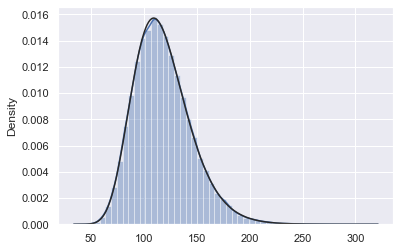

In [57]:
sns.distplot([x[-1] for x in pxs], fit=stats.lognorm);

In [58]:
stats.lognorm.fit([x[-1] for x in pxs])

(0.2272194904466377, 0.4333924933741923, 114.6720742690411)

In [61]:
np.mean([x[-1] for x in pxs])

118.10399280568818

In [62]:
spot * np.exp(drift * years + 0.5 * years * sigma**2)

1.1801009669158433

In [63]:
(np.exp(years * sigma**2) - 1) * (np.exp(2 * years * drift + years * sigma**2))

0.07315999508390197

In [64]:
np.var([x[-1] / spot for x in pxs])

0.07335012540339236

## Step 2: Wrap it in a function

In [192]:
# determine our process parameters
spot = 100
sigma = 0.16
drift = 0.07

# determine our sim settings
# i.e. we want 10,000 sets of 504 random numbers
sims = 100000
points = 252
years = 2

In [168]:
def generate_paths(spot, drift, sigma, years, points, sims):
    
    # create numpy PCG PRNG
    rng = np.random.default_rng(seed=123)
    # create random numbers
    dW = rng.normal(size=(sims, points * years))
    # get our scaled random deviations
    scaled_dW = dW * (sigma / points**0.5)
    # add on the drift
    daily_devs = (drift / points) + scaled_dW
    # cumsum them as log returns additive
    cum_rets = np.cumsum(daily_devs, axis=1)
    # add in 0 at start for starting price
    cum_rets = np.insert(cum_rets, 0, 0, axis=1)
    # create price series
    pxs = spot * np.exp(cum_rets)
    
    return daily_devs, pxs

In [193]:
rets, pxs = generate_paths(spot, drift, sigma, years, points, sims)

## Step 3: Create delta function

Now we have price series created we need a way to compute the Black-Scholes delta for each point in time for each simulation. Ideally this should be very efficient.

In [115]:
def bs_d_one(S, K, mu, sigma, delta_T):
    
    return (1 / (sigma * delta_T**0.5)) * (np.log(S / K) + (mu + (sigma**2)/2) * delta_T)

In [116]:
def bs_delta(S, K, mu, sigma, delta_T, call=True):

    d_one = bs_d_one(S, K, mu, sigma, delta_T)
    if call:
        return stats.norm.cdf(d_one)
    else:
        return stats.norm.cdf(d_one) - 1

In [221]:
def compute_prices(pxs, K, mu, sigma, points, years, call=True):
    
    # create time vector
    times = np.linspace(0, years, (points*years) + 1)[::-1]
    # calculate d1
    d_one = bs_d_one(pxs, K, mu, sigma, times)
    d_two = d_one - sigma * times**0.5
    # compute N(d1)
    deltas = stats.norm.cdf(d_one)
    # compute prices
    prices = pxs * deltas - stats.norm.cdf(d_two) * K * np.exp(-drift * times)
    
    return prices, deltas

In [303]:
def compute_deltas(pxs, K, mu, sigma, points, years):
    
    # create time vector
    times = np.linspace(0, years, (points*years) + 1)[::-1]
    # compute all deltas
    deltas = bs_delta(pxs, K, mu, sigma, times)
    return deltas

In [820]:
# determine our process parameters
spot = 100
strike = 100
drift = 0.0
sigma = 0.20

# determine our sim settings
# i.e. we want 10,000 sets of 504 random numbers
sims = 1000
points = 252
years = 1

# generate returns and price series
rets, pxs = generate_paths(spot, drift, sigma, years, points, sims)

# compute deltas
deltas = compute_deltas(pxs, strike, drift, sigma, points, years)

In [821]:
call_pxs, deltas = compute_prices(pxs, strike, drift, sigma, points, years, call=True)

## Step 4: Create replicating portfolio value function

We have our 3 building blocks:
 - raw price series
 - option price series
 - option delta series

This is everything we need to be able to start computing daily values of the replicating portfolio.

### Cash Portfolio

Strangely despite it's name this is the hardest one. Initially we:
 - sell the option and receive cash
 - borrow cash and buy the delta hedge

Overall we will be left with a negative cash balance that we need to borrow and finance daily. The pnl aspect of this is the paying of interest on our net borrowed amount daily. We then need to adjust this cash balance by:
 - updating with interest payments
 - updating with cashflows generated by delta hedging

Finally we can think of our pnl as the interest payments on all of this.

In [822]:
times = np.linspace(0, years, (points*years) + 1)[::-1]

In [823]:
def gen_cash_portfolio(pxs, call_pxs, deltas, risk_free, points, years):
    
    # required for rate calculations
    times = np.linspace(0, years, (points*years) + 1)[::-1]
    
    # we receive the option premium for selling it
    prem_vals = call_pxs[0,0]
    
    # we then need to borrow cash to buy the delta hedge
    start_delta_cost = - deltas[:,0] * pxs[:,0]
    
    # this gives us our starting cash balance
    start_cash_bals = start_delta_cost + prem_vals
    
    # now we can calculate the cash bal change from re-delta hedging
    delta_chgs = np.diff(deltas, axis=1)
    delta_cash_chgs = - delta_chgs * pxs[:,1:]
    
    # to calculate pnl for t periods we need t+1 points
    # concat on the starting cash balance
    cash_chgs = np.concatenate((start_cash_bals[:, None], delta_cash_chgs), axis=1)
    
    # now let's compute our rolling cash balances by compounding interest
    # and updating with delta hedging cashflows
    cash_bals = cash_chgs.T[0]

    for cf in cash_chgs.T[1:]:
        prev_bals = cash_bals[-1]
        new_bals = prev_bals * (1 + risk_free/points) + cf
        cash_bals = np.vstack([cash_bals, new_bals])
    
    cash_pnls = cash_bals.T * drift / points
    
    return cash_pnls[:,:-1], cash_bals

In [824]:
cash_pnls, cash_bals = gen_cash_portfolio(pxs, call_pxs, deltas, drift, points, years)

In [825]:
# compute our stock price changes
pxs_chg = np.diff(pxs, axis=1)

# compute our option price changes
call_pxs_chg = np.diff(call_pxs, axis=1)

# compute our delta pnls
delta_pnls = pxs_chg * deltas[:,:-1]

In [826]:
total_pnls = np.cumsum(cash_pnls, axis=1) + np.cumsum(delta_pnls, axis=1) - np.cumsum(call_pxs_chg, axis=1)

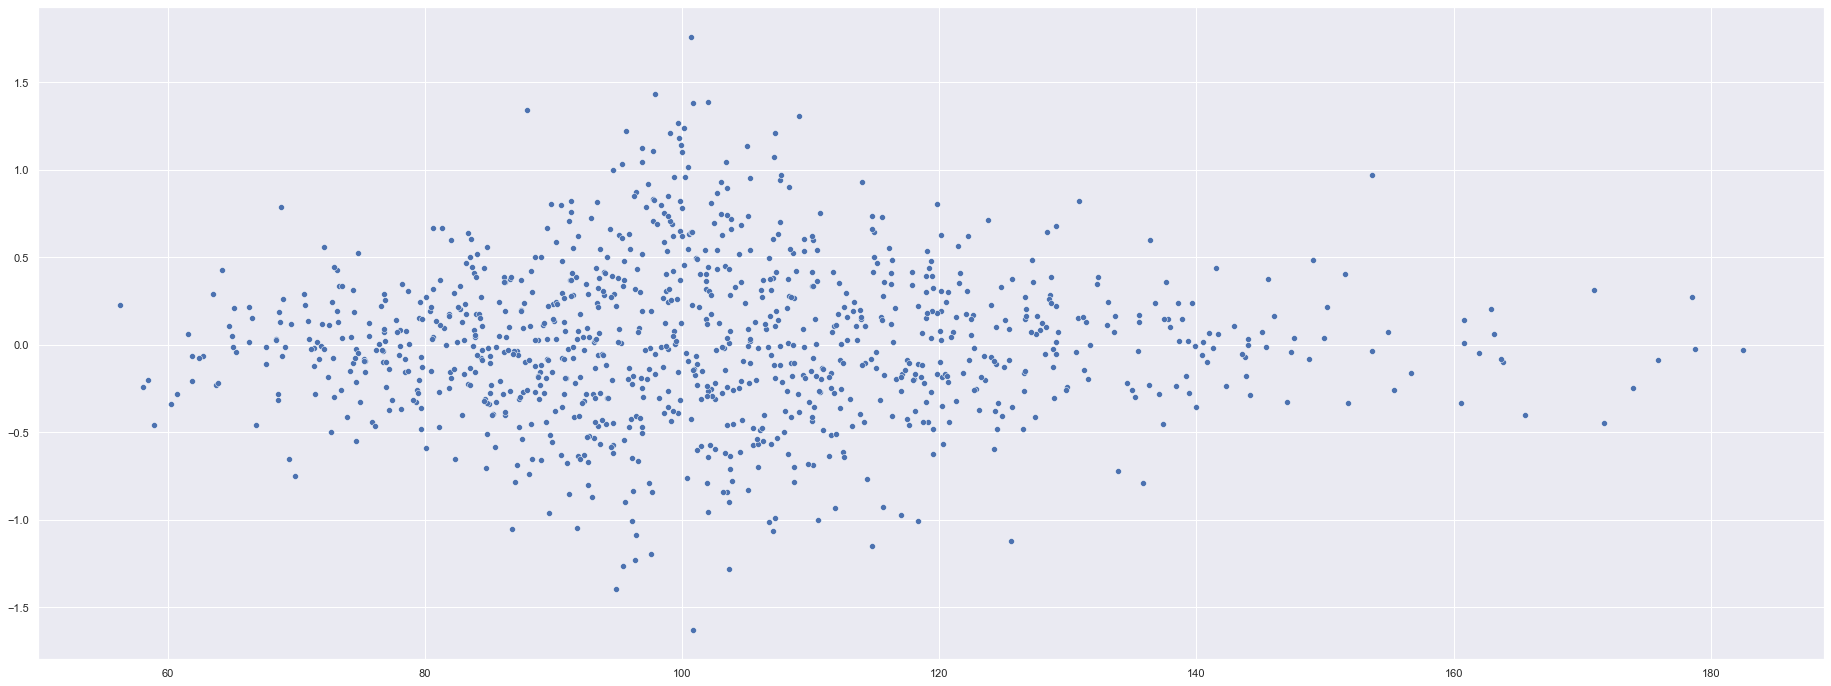

In [827]:
fig, ax = plt.subplots(figsize=(32, 12))

sns.scatterplot(pxs[:,-1], total_pnls[:,-1], ax=ax);

<AxesSubplot:>

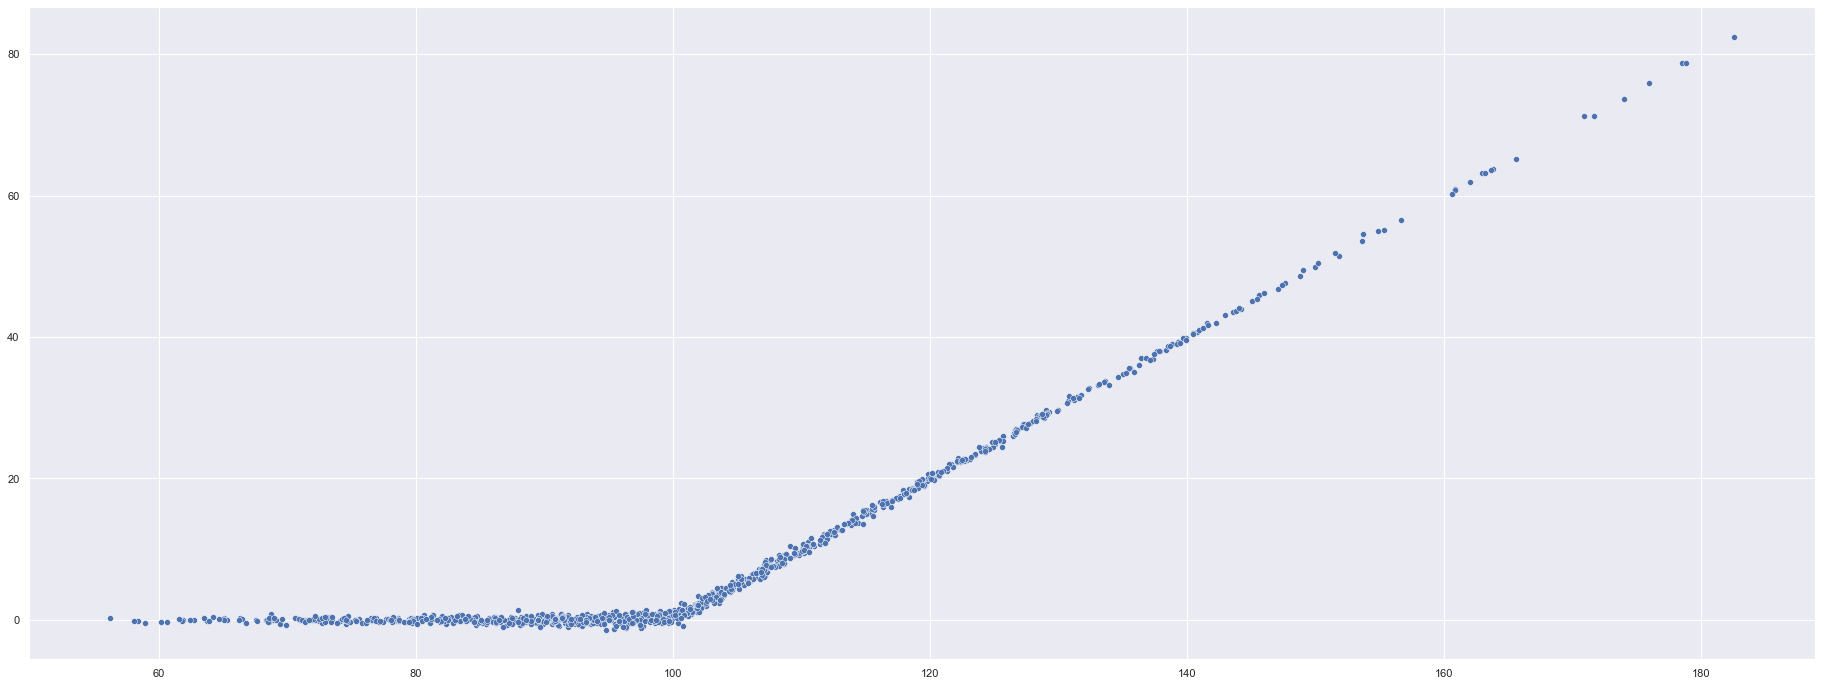

In [828]:
fig, ax = plt.subplots(figsize=(32, 12))

sns.scatterplot(pxs[:,-1], total_pnls[:,-1] + call_pxs[:,-1], ax=ax)

In [830]:
np.std(total_pnls[:,-1])

0.4449088803964829

In [831]:
call_pxs[0,0]

7.965567455405804

In [832]:
0.44 / 7.96

0.05527638190954774

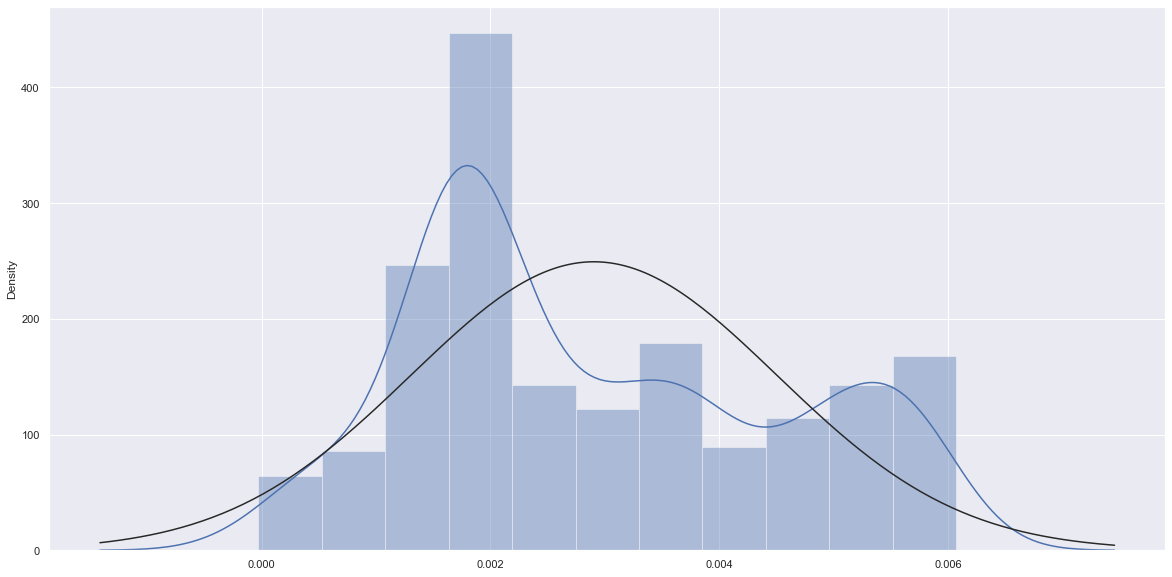

In [810]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.distplot(np.mean(total_pnls, axis=0), fit=stats.norm, ax=ax);